#### Check protein sequence consistency between picr and hamster refseq
Since our goal is to improve the annotation, first we check how many protein sequences in the picr annotation are consistent with hamster refseq proteins
Since they use different ids, we use gene names to map between refseq and picr annotation

In [1]:
from Bio import SeqIO
import gzip,re,sarge,os
import pandas as pd
from itertools import product
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn
import numpy as np

In [2]:
picr_tr   = '/data/genome/hamster/picr/Other/picr.maker.transcripts'
picr_pr   = '/data/genome/hamster/picr/Other/picr.maker.prot'
picr_gff  = '/data/genome/hamster/picr_old/picr_merge7.gff3'
refseq_tr = '/data/genome/hamster/ncbi_refseq/hamster_rna.fa'
refseq_pr = '/data/genome/hamster/ncbi_refseq/hamster_pr.fa'
refseq_id = '/data/genome/hamster/ncbi_refseq/all_id.txt'

In [3]:
def picr_gene_name_dic(gff):
    '''{genename:geneid}'''
    dic = {}
    with open(gff) as p:
        for line in p:
            if line.startswith('#'): continue
            item = line.strip().split('\t')
            if item[2] != 'gene': continue
            try:
                gid = re.search('(?<=gene_id=).+?(?=[,;]|$)',item[8]).group(0)
            except:
                continue
            try:
                name= re.search('(?<=Name=).+?(?=[;,]|$)',item[8]).group(0).upper()
            except:
                continue
            if name in dic:
                dic[name].append(gid)
            else:
                dic[name] = [gid]
    return dic

In [4]:
# get picr name:gene id mapping
picr_g_name_dic = picr_gene_name_dic(picr_gff)
# get refseq name:protein mapping
df = pd.read_csv(refseq_id,sep='\t',header=0)
df = df[df['PrAccess'].values != '-']
refseq_g_pr_dic = {k.upper():list(v) for k,v in df.groupby('GeneSymbol')['PrAccess']}
refseq_g_tr_dic = {k.upper():list(v) for k,v in df.groupby('GeneSymbol')['TrAccess']}
# get common genes
common_genes = list(set(picr_g_name_dic.keys()).intersection(refseq_g_pr_dic.keys()))
print('there are',len(picr_g_name_dic.keys()),'gene names in picr')
print('there are',len(refseq_g_pr_dic.keys()),'gene names in refseq')
print('there are',len(common_genes), 'gene names overlap between refseq and picr genome')

('there are', 18109, 'gene names in picr')
('there are', 20347, 'gene names in refseq')
('there are', 13202, 'gene names overlap between refseq and picr genome')


In [5]:
def picr_refseq_blast(map_out,picr_fa,refseq_fa,picr_g_name_dic,refseq_g_trpr_dic,blast):
    '''
    * picr_fa: picr protein/mRNA sequence in fa format
    * refseq_fa: refseq protein/mRNA sequence in fa format
    * map_out: store results
    '''
    # index protein sequences
    picr   = SeqIO.index(picr_fa,'fasta')
    refseq = SeqIO.index(refseq_fa,'fasta')

    if os.path.exists(map_out): os.remove(map_out)
    with open(map_out,'a') as f:
        for g in common_genes:
            qry = 'query.fa'
            sub = 'subject.fa'
            picr_records = [picr[gene+'-RA'] for gene in picr_g_name_dic[g]]
            SeqIO.write(picr_records,qry,'fasta')
            refseq_records = [refseq[gene] for gene in refseq_g_trpr_dic[g]]
            SeqIO.write(refseq_records,sub,'fasta')
            res = sarge.get_stdout(blast + ' -query {q} -subject {s} \
                            -outfmt \'6 qacc sacc pident length mismatch \
                            gapopen qstart qend sstart send evalue \
                            qlen slen\' -num_alignments 1'.format(q=qry,s=sub))
            f.write(res)

In [6]:
def map_plot(cmp_df,feature):
    # percent mapping distribution
    cmp_df = cmp_df.groupby(['qry','sub'])['pident','diff_len'].mean()
    plt.figure()
    ax = cmp_df['pident'].plot.hist(bins=50,title='picr blast to refseq '+feature)
    _ = ax.set_xlabel('map percentage')
    # 100% match distance distribution
    plt.figure()
    full_match = cmp_df.query('(-200 < diff_len < 200 ) and (pident==100)')
    ax = full_match['diff_len'].plot.hist(bins=100)
    _ = ax.set_title('length difference between picr and refseq ' +feature )
    _ = ax.set_xlabel('length difference')

In [7]:
trmap_out = '/data/shangzhong/Picr_assembly/Annotation/picr_refseq_tr_map.txt'
# picr_refseq_blast(trmap_out,picr_tr,refseq_tr,picr_g_name_dic,refseq_g_tr_dic,'blastn')
prmap_out = '/data/shangzhong/Picr_assembly/Annotation/picr_refseq_pr_map.txt'
# picr_refseq_blast(prmap_out,picr_pr,refseq_pr,picr_g_name_dic,refseq_g_pr_dic,'blastp')

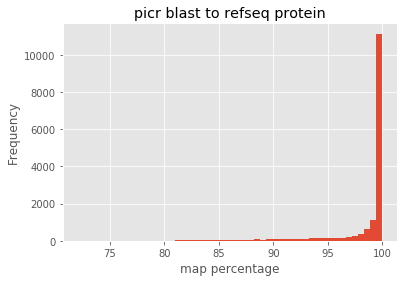

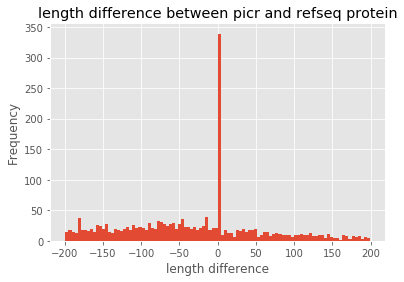

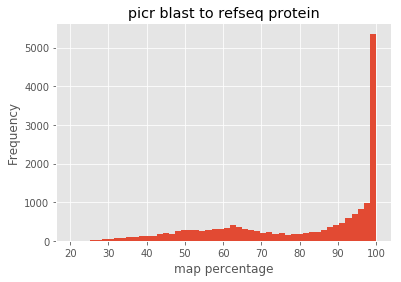

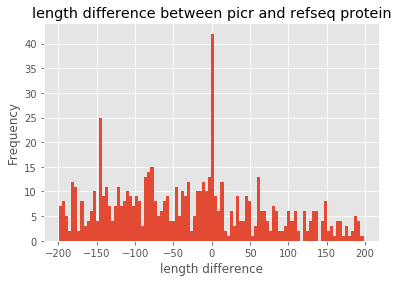

In [8]:
trmap_out = '/data/shangzhong/Picr_assembly/Annotation/picr_refseq_tr_map.txt'
trcmp_df = pd.read_csv(trmap_out,sep='\t',header=None,names=['qry','sub','pident','len','mm',
            'gapopen','qstart','qend','sstart','send','evalue','qlen','slen'])
trcmp_df['diff_len'] = trcmp_df['qlen'] - trcmp_df['slen']
map_plot(trcmp_df,'protein')
# plot protein
prmap_out = '/data/shangzhong/Picr_assembly/Annotation/picr_refseq_pr_map.txt'
prcmp_df = pd.read_csv(prmap_out,sep='\t',header=None,names=['qry','sub','pident','len','mm',
            'gapopen','qstart','qend','sstart','send','evalue','qlen','slen'])
prcmp_df['diff_len'] = trcmp_df['qlen'] - trcmp_df['slen']
map_plot(prcmp_df,'protein')

In [9]:
# fragments that are perfectly match and how many of them are full length of qry or sub
print prcmp_df.query('pident == 100')['qry'].unique().shape
print prcmp_df.query('(pident == 100) and ((len==qlen) or (len==slen))').shape

(5313,)
(3193, 14)


### Then let's look at the protein splice sites consitency between picr and hamster

In [10]:
cmp_prs = list(set(prcmp_df['sub'].tolist()))
cmp_prs = [p.split('.')[0] for p in cmp_prs]
picr_cmp_prs = list(set(prcmp_df['qry'].tolist()))

In [ ]:
from pybedtools import BedTool
draft_gff = '/data/genome/hamster/picr_old/Other/picr_draft.gff3'
draft_gff_df = pd.read_csv(draft_gff,sep='\t',header=None,comment='#')
draft_gff_df = draft_gff_df[draft_gff_df[2].values=='CDS']
draft_gff_df = draft_gff_df.reset_index(drop=True)
draft_gff_df['pr'] = draft_gff_df[8].map(lambda x: re.search('(?<=Target=).+?(?=\.)',x).group(0))
draft_gff_df = draft_gff_df[[0,3,4,'pr',5,6]]
print('there are '+str(draft_gff_df.shape[0])+' CDS in draft annotation')
draft_gff_df = draft_gff_df[draft_gff_df['pr'].isin(cmp_prs)]
print('there are '+str(draft_gff_df.shape[0])+' CDS in draft annotation whose genes map to picr')
draft_gff_df.columns = ['dr_chr','dr_s','dr_e','dr_pr','dr_score','dr_str']
draft_gff_df = draft_gff_df.sort_values(by=['dr_chr','dr_s'])
draft_gff_df = draft_gff_df.reset_index(drop=True)
# bed read
draft_gff_bed = BedTool.from_dataframe(draft_gff_df)

In [ ]:
picr_gff_df = pd.read_csv(picr_gff,sep='\t',header=None,comment='#')
picr_gff_df = picr_gff_df[picr_gff_df[2].values=='CDS']
picr_gff_df = picr_gff_df.reset_index(drop=True)
picr_gff_df['pr'] = picr_gff_df[8].map(lambda x: re.search('(?<=Parent=).+?(?=;)',x).group(0))
picr_gff_df = picr_gff_df[[0,3,4,'pr',5,6]]
print('there are '+str(picr_gff_df.shape[0])+' CDS in draft annotation')
picr_gff_df = picr_gff_df[picr_gff_df['pr'].isin(picr_cmp_prs)]
print('there are '+str(picr_gff_df.shape[0])+' CDS in draft annotation whose genes map to refseq')
picr_gff_df.columns = ['chr','s','e','pr','score','str']
picr_gff_df = picr_gff_df.sort_values(by=['chr','s'])
picr_gff_df = picr_gff_df.reset_index(drop=True)
# bed read in 
picr_gff_bed = BedTool.from_dataframe(picr_gff_df)

In [ ]:
columns = ['chr','s','e','pr','score','str',\
           'dr_chr','dr_s','dr_e','dr_pr','dr_score','dr_str','num_bases']
intersect_df = picr_gff_bed.intersect(draft_gff_bed,s=True,wo=True).to_dataframe(names=columns)
intersect_df['left_dist'] = intersect_df['dr_s'] - intersect_df['s']
intersect_df['right_dist'] = intersect_df['dr_e'] - intersect_df['e']

In the draft annotation, there are many genes with isoforms, so till now the intersect between draft and picr CDS regions would have many repetitive regions. so next I will extract the the best match based on the picr_refseq_pr_map.

In [ ]:
picr_refseq_df = pd.read_csv(prmap_out,sep='\t',header=None,
                             usecols=[0,1],names=['picr','draft'])
picr_refseq_pr_dic = picr_refseq_df.set_index('picr')['draft'].to_dict()

In [ ]:
def keep_row(row,picr_refseq_pr_dic):
    if row['pr'] in picr_refseq_pr_dic:
        if picr_refseq_pr_dic[row['pr']].split('.')[0] == row['dr_pr']:
            return True
        else:
            return False
    else:
        return False
cri = intersect_df.apply(lambda row: keep_row(row,picr_refseq_pr_dic),axis=1)
intersect_df = intersect_df[cri]
intersect_df = intersect_df.reset_index(drop=True)

In [ ]:
cds_map_df = intersect_df.set_index(['pr','dr_pr'])[['chr','s','e',\
        'dr_chr','dr_s','dr_e','left_dist','right_dist']].drop_duplicates()

In [ ]:
print('There are '+str(cds_map_df.shape[0]) + ' Overlapped CDS')
inconsist_CDS = cds_map_df.query('(left_dist != 0) or (right_dist != 0)').shape[0]
print('There are '+str(inconsist_CDS)+' CDS that are not consistent between refseq and picr')
print('Percentage is 22.7%')
inconsist_rnas = cds_map_df.query('(left_dist != 0) or (right_dist != 0)')
print('There are '+str(len(set(inconsist_rnas.index.get_level_values(0))))+' inconsistent RNAs')

In [ ]:
ax = inconsist_rnas.query('(abs(right_dist)<5000) and (abs(left_dist)<5000)')[['left_dist','right_dist']].plot.hist(bins=500)
ax.set_xlim(-500,500)
ax.set_title('CDS distance distribution between picr and refseq')

#### The follwing is to check if picr protein is the same as picr annotation

In [ ]:
# check the consistency between picr genome and picr annotation
picr_fn = '/data/genome/hamster/picr/picr.fa'
picr_handle = SeqIO.index(picr_fn,'fasta')

In [ ]:
# check if protein sequence from picr genome is the same with those one provided
gff_df = pd.read_csv(picr_gff,sep='\t',header=None,comment='#',names=[
    'chr','source','feature','start','end','score','strand','frame','anno'])

gff_df = gff_df[gff_df['feature'].values=='CDS']
gff_df = gff_df.reset_index(drop=True)

gff_df['prid'] = gff_df['anno'].map(lambda x:re.search('(?<=ID=).+?(?=:)',x).group(0))

In [ ]:
def get_gene_seq(self,ref_dic,gid,id_type='pr'):
        '''this function gets seqeunce of a transcript or protein
        * self: df with 
        * ref_dic: handle reads using SeqIO.index(fa,'fasta')
        * gid: gene id
        '''
        df = self
        if id_type == 'tr':
            feature = 'exon'
            id_t = 'trid'
        elif id_type == 'pr':
            feature = 'CDS'
            id_t = 'prid'
        region_df = df[(df['feature'].values==feature) & (df[id_t].values==gid)]
        region_df = region_df.sort_values(by='start')
        # get sequence
        scaff = region_df['chr'].tolist()[0]
        scaff_seq = ref_dic[scaff].seq
        strand = region_df['strand'].tolist()[0]
        
        g_seq = ''
        for s,e in zip(region_df['start'],region_df['end']):
            g_seq += scaff_seq[int(s)-1:int(e)]
        # consider strand
        if strand == '-':
            g_seq = g_seq.reverse_complement()
        
        if id_type == 'pr':
            g_seq = g_seq.translate()
        return str(g_seq)

In [ ]:
proteins = list(set(gff_df['prid'].tolist()))

In [ ]:
for pr in proteins:
    gff_seq = get_gene_seq(gff_df,picr_handle,pr)
    fn_seq  = picr[pr].seq
    if gff_seq != fn_seq:
        print pr, 'is not consistent'